In [71]:
# Importa librerías
import gc
import os
import logging
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.datasets import make_imbalance
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
warnings.filterwarnings('ignore')

In [79]:
# Carga dataset en variable
train_df = pd.read_csv("santander-customer-transaction-prediction/train.csv")
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,0.100490,10.679914,-1.627622,10.715192,6.796529,11.078333,-5.065317,5.408949,16.545850,0.284162,...,3.234440,7.438408,1.927839,3.331774,17.993784,-0.142088,2.303335,8.908158,15.870720,-3.326537
std,0.300653,3.040051,4.050044,2.640894,2.043319,1.623150,7.863267,0.866607,3.418076,3.332634,...,4.559922,3.023272,1.478423,3.992030,3.135162,1.429372,5.454369,0.921625,3.010945,10.438015
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.453850,-4.740025,8.722475,5.254075,9.883175,-11.200350,4.767700,13.943800,-2.317800,...,-0.058825,5.157400,0.889775,0.584600,15.629800,-1.170700,-1.946925,8.252800,13.829700,-11.208475
50%,0.000000,10.524750,-1.608050,10.580000,6.825000,11.108250,-4.833150,5.385100,16.456800,0.393700,...,3.203600,7.347750,1.901300,3.396350,17.957950,-0.172700,2.408900,8.888200,15.934050,-2.819550
75%,0.000000,12.758200,1.358625,12.516700,8.324100,12.261125,0.924800,6.003000,19.102900,2.937900,...,6.406200,9.512525,2.949500,6.205800,20.396525,0.829600,6.556725,9.593300,18.064725,4.836800
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


# Balanceo del set de datos

## Balanceo por undersampling

Para balancear el set de datos por undersampling se eliminan registros de la clase predominante de forma aleatoria. De esta forma se espera no perder poder de generalización al mismo tiempo que se balancean la cantidad de registros de cada clase.

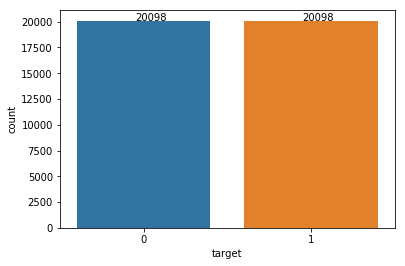

In [82]:
# Balanceo por undersampling
undersampling = RandomUnderSampler(sampling_strategy='not minority')
X_res, Y_res = undersampling.fit_resample(train_df, train_df.target)

ax = sns.countplot(Y_res)
plt.xlabel('target')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.35, p.get_height()+50))

Podemos ver que ahora el set de datos tiene muchos menos registros de clase 0 que antes, y exactamente el mismo número que el de registros de clase 1 (que permaneció casi sin cambios)

In [85]:
def save_csv_balanced(variables, target, path):
    header = ["ID_code", "target"]
    for i in range(len(variables[0]) - 2):
        header.append("var_" + str(i))
    df = pd.DataFrame(variables)
    df.to_csv(path, header=header, index=None)

save_csv_balanced(X_res, Y_res, "santander-customer-transaction-prediction/train_undersampled.csv")

Guardamos el set de datos en un archivo para utilizarlo en otros notebooks en el resto del trabajo

In [86]:
train_df = pd.read_csv("santander-customer-transaction-prediction/train_undersampled.csv")
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,...,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000,40196.000000
mean,0.500000,10.905527,-1.348542,10.921045,6.832666,11.088927,-4.724519,5.485806,16.541605,0.373130,...,3.573742,7.634772,1.848314,3.220588,17.903627,-0.089494,2.465059,8.861001,15.668420,-3.012970
std,0.500006,3.166639,4.122191,2.741089,2.060382,1.634050,8.001602,0.895648,3.415671,3.336293,...,4.694220,3.113251,1.484083,4.023012,3.161225,1.453244,5.502245,0.934712,3.120659,10.421424
min,0.000000,0.408400,-14.037000,2.789200,0.374000,5.277800,-29.777300,2.496000,5.349700,-10.505500,...,-13.454700,-2.343000,-3.317700,-11.783400,8.957500,-5.018500,-14.020400,5.960600,6.558700,-38.852800
25%,0.000000,8.556975,-4.495975,8.831600,5.286700,9.884350,-10.948225,4.818700,13.943700,-2.198800,...,0.151500,5.272675,0.793150,0.476475,15.546600,-1.145900,-1.803150,8.210500,13.598600,-10.823150
50%,0.500000,10.727950,-1.320450,10.811450,6.865100,11.112250,-4.485800,5.472300,16.438850,0.470550,...,3.529550,7.569650,1.800350,3.280650,17.862700,-0.130000,2.572650,8.842900,15.734550,-2.494950
75%,1.000000,13.052000,1.648550,12.750975,8.361650,12.281525,1.241650,6.100100,19.080325,3.022800,...,6.834350,9.730700,2.879625,6.116775,20.317525,0.894000,6.722325,9.559750,17.930725,5.179400
max,1.000000,19.458300,9.029800,19.353000,12.938900,15.831700,16.743700,8.285200,27.072000,9.273200,...,18.440900,16.520500,7.647600,17.150400,27.528400,4.088100,17.684100,11.953400,26.034600,27.531900


Vemos que los valores medios son aproximados a los valores medios medidos en el set de datos original.

## Balanceo por oversampling

In [92]:
# Recarga de todos los registros
train_df = pd.read_csv("santander-customer-transaction-prediction/train.csv")
train_df.shape

(200000, 202)

In [93]:
# Balanceo por oversampling
oversampling = RandomOverSampler(sampling_strategy='not majority')
X_res, Y_res = oversampling.fit_resample(train_df, train_df.target)

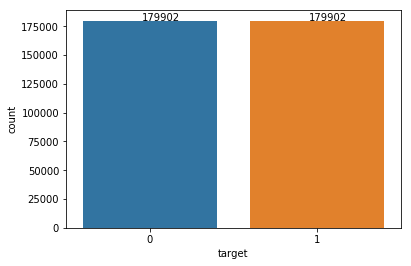

In [94]:
ax = sns.countplot(Y_res)
plt.xlabel('target')

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+0.35, p.get_height()+50))


Puede verse que ahora el número de registros de tipo 0 se mantiene cercano al original, mientras que el número de registros de tipo 1 crece hasta igualar al número de registros de tipo 0. Volvemos a repetir el experimento con este set de datos:

In [95]:
save_csv_balanced(X_res, Y_res, "santander-customer-transaction-prediction/train_oversampled.csv")

In [96]:
train_df = pd.read_csv("santander-customer-transaction-prediction/train_oversampled.csv")
train_df.describe()

,target,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
count,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,...,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000,359804.000000
mean,0.500000,10.890528,-1.349842,10.915189,6.827433,11.103555,-4.755291,5.486014,16.541165,0.365591,...,3.579543,7.627327,1.841682,3.241852,17.896298,-0.088235,2.474913,8.866924,15.655890,-2.978807
std,0.500001,3.152136,4.135256,2.740965,2.056778,1.633766,7.989081,0.896728,3.421307,3.336674,...,4.691001,3.113880,1.483665,4.024935,3.166245,1.455370,5.508570,0.936547,3.124732,10.442096
min,0.000000,0.408400,-15.043400,2.117100,-0.040200,5.074800,-32.562600,2.347300,5.349700,-10.505500,...,-14.093300,-2.691700,-3.814500,-11.783400,8.694400,-5.261000,-14.209600,5.960600,6.299300,-38.852800
25%,0.000000,8.555100,-4.514425,8.824500,5.282900,9.898400,-10.954725,4.816800,13.925400,-2.225900,...,0.162800,5.266300,0.789000,0.487300,15.529900,-1.143625,-1.775225,8.213700,13.571700,-10.795250
50%,0.500000,10.729550,-1.321700,10.792300,6.862200,11.128850,-4.514050,5.474400,16.450800,0.474800,...,3.558950,7.550700,1.794600,3.303900,17.863100,-0.123700,2.605800,8.849200,15.711900,-2.464900
75%,1.000000,13.015400,1.660925,12.744500,8.352325,12.295725,1.204275,6.100000,19.080825,3.014400,...,6.852300,9.726900,2.867500,6.146025,20.317500,0.897800,6.737500,9.565300,17.936225,5.201500
max,1.000000,20.315000,10.376800,19.353000,13.188300,16.671400,17.251600,8.447700,27.691800,10.151300,...,18.440900,16.716500,8.402400,18.281800,27.928800,4.272900,18.321500,12.000400,26.079100,28.500700


Nuevamente no notamos grandes cambios en cuanto al valor medio de cada una de las variables del set de datos. Intentaremos entrenar algunos modelos con estos sets de datos y validarlos con el set de datos original para ver si esto resulta en mejores predicciones durante el estudio de *feature engineering*.